### DBSCAN: Step-by-Step Guide
This notebook walks through DBSCAN clustering on a synthetic dataset:

1. Generate data (clusters + outliers)

2. Visualize the raw data

3. Use a **k-distance plot** to estimate a good `eps`

4. Run **DBSCAN** and visualize results

5. Report metrics (clusters, noise, silhouette)

6. **Parameter sweep** over `eps` and `min_samples` with a heatmap to help tune DBSCAN



Run the cells from top to bottom. All charts use matplotlib, one plot per figure, and no manual colors are set.


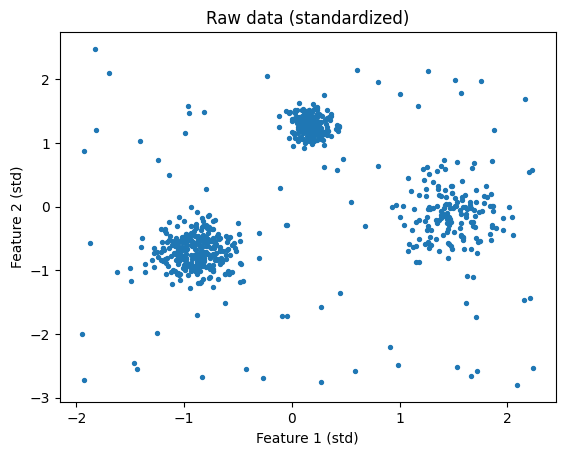

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Reproducibility
rng = np.random.RandomState(42)

# 1) Generate data: three clusters with different densities + uniform noise
X_blobs, y_blobs = make_blobs(
    n_samples=[300, 200, 150],
    centers=[(-5, -2), (0, 5), (6, 0)],
    cluster_std=[0.9, 0.5, 1.2],
    random_state=rng
)

n_noise = 80
noise = rng.uniform(low=-10, high=10, size=(n_noise, 2))

X = np.vstack([X_blobs, noise])

# Scale features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2) Visualize raw data
plt.figure()
plt.title("Raw data (standardized)")
plt.scatter(X_std[:, 0], X_std[:, 1], s=8)
plt.xlabel("Feature 1 (std)")
plt.ylabel("Feature 2 (std)")
plt.show()


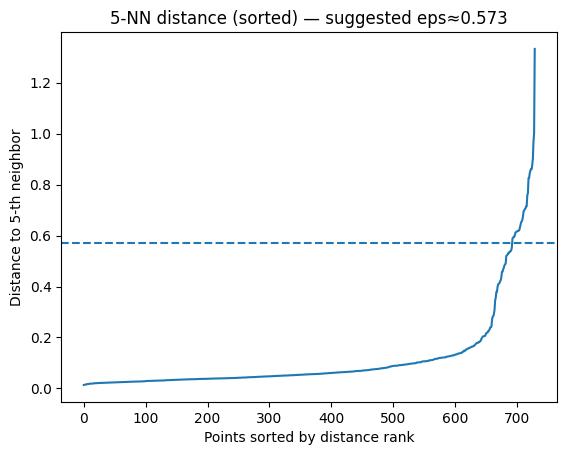

Suggested eps (95th percentile): 0.573


In [2]:

# 3) k-distance plot to estimate eps
min_samples = 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_std)
distances, indices = nbrs.kneighbors(X_std)
kth_distances = np.sort(distances[:, -1])

eps_suggested = float(np.percentile(kth_distances, 95))

plt.figure()
plt.title(f"{min_samples}-NN distance (sorted) — suggested eps≈{eps_suggested:.3f}")
plt.plot(kth_distances)
plt.axhline(y=eps_suggested, linestyle="--")
plt.xlabel("Points sorted by distance rank")
plt.ylabel(f"Distance to {min_samples}-th neighbor")
plt.show()

print(f"Suggested eps (95th percentile): {eps_suggested:.3f}")


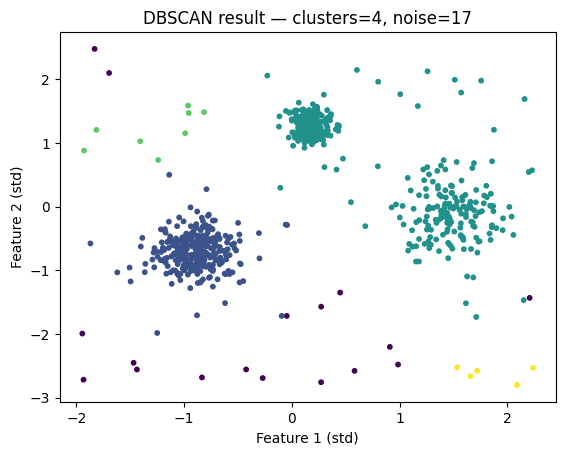

=== DBSCAN Summary ===
eps used        : 0.573
min_samples     : 5
clusters found  : 4
noise points    : 17 (2.3%)
silhouette (excl. noise): 0.5452144785156179


In [3]:

# 4) Run DBSCAN with the suggested parameters
dbscan = DBSCAN(eps=eps_suggested, min_samples=min_samples)
labels = dbscan.fit_predict(X_std)

unique_labels = set(labels)
n_clusters = len([l for l in unique_labels if l != -1])
n_noise_found = int(np.sum(labels == -1))

# Silhouette on non-noise points when >=2 clusters exist
if n_clusters >= 2 and np.sum(labels != -1) > 1:
    sil = float(silhouette_score(X_std[labels != -1], labels[labels != -1]))
else:
    sil = None

plt.figure()
plt.title(f"DBSCAN result — clusters={n_clusters}, noise={n_noise_found}")
plt.scatter(X_std[:, 0], X_std[:, 1], c=labels, s=10)
plt.xlabel("Feature 1 (std)")
plt.ylabel("Feature 2 (std)")
plt.show()

print("=== DBSCAN Summary ===")
print(f"eps used        : {eps_suggested:.3f}")
print(f"min_samples     : {min_samples}")
print(f"clusters found  : {n_clusters}")
print(f"noise points    : {n_noise_found} ({n_noise_found / len(X_std)*100:.1f}%)")
print(f"silhouette (excl. noise): {sil if sil is not None else 'N/A (need >=2 clusters w/o noise)'}")


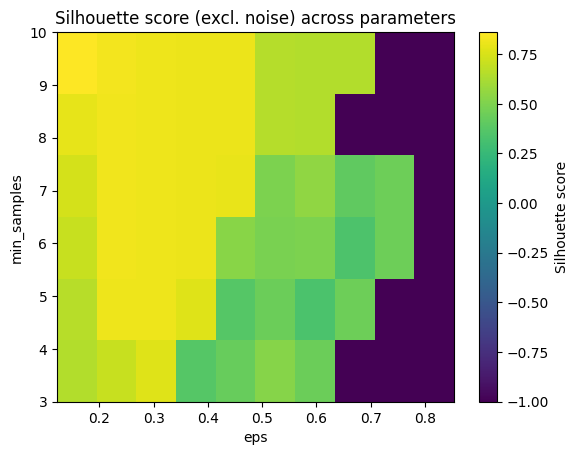

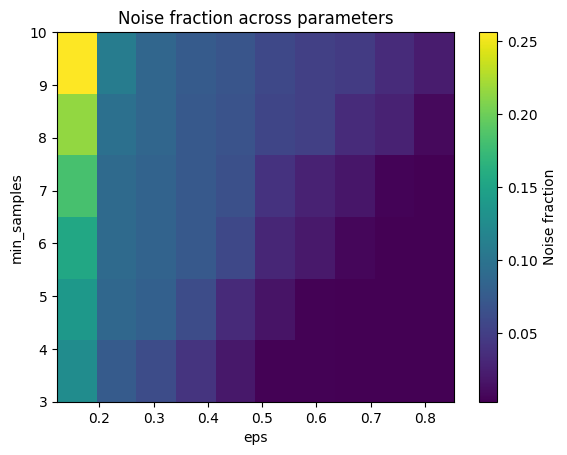

,min_samples,eps,silhouette_excl_noise,noise_fraction,clusters
50,10,0.121862,0.861161,0.256164,3
51,10,0.203126,0.829200,0.109589,3
41,8,0.203126,0.820919,0.095890,3
31,6,0.203126,0.818439,0.090411,3
21,5,0.203126,0.818439,0.090411,3
11,4,0.203126,0.817141,0.087671,3
42,8,0.284390,0.816554,0.086301,3
52,10,0.284390,0.816554,0.086301,3
32,6,0.284390,0.814692,0.083562,3
22,5,0.284390,0.814692,0.083562,3


In [4]:

# 5) Parameter sweep for eps and min_samples
eps_grid = np.linspace(np.percentile(kth_distances, 80), np.percentile(kth_distances, 99), 10)
min_samples_grid = [3, 4, 5, 6, 8, 10]

scores = np.full((len(min_samples_grid), len(eps_grid)), np.nan)
noise_frac = np.zeros_like(scores)
results_rows = []

for i, ms in enumerate(min_samples_grid):
    for j, eps in enumerate(eps_grid):
        model = DBSCAN(eps=float(eps), min_samples=int(ms))
        labs = model.fit_predict(X_std)

        # Silhouette on non-noise if >=2 clusters
        if len(set(l for l in labs if l != -1)) >= 2 and np.sum(labs != -1) > 1:
            s = silhouette_score(X_std[labs != -1], labs[labs != -1])
        else:
            s = -1.0

        nf = np.sum(labs == -1) / len(labs)
        scores[i, j] = s
        noise_frac[i, j] = nf
        results_rows.append({
            "min_samples": ms,
            "eps": float(eps),
            "silhouette_excl_noise": float(s),
            "noise_fraction": float(nf),
            "clusters": len(set([l for l in set(labs) if l != -1]))
        })

# Heatmap: silhouette
plt.figure()
plt.title("Silhouette score (excl. noise) across parameters")
plt.imshow(scores, aspect="auto", origin="lower",
           extent=[eps_grid[0], eps_grid[-1], min_samples_grid[0], min_samples_grid[-1]])
plt.colorbar(label="Silhouette score")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

# Heatmap: noise fraction
plt.figure()
plt.title("Noise fraction across parameters")
plt.imshow(noise_frac, aspect="auto", origin="lower",
           extent=[eps_grid[0], eps_grid[-1], min_samples_grid[0], min_samples_grid[-1]])
plt.colorbar(label="Noise fraction")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

# Show top 10 rows
results_df = pd.DataFrame(results_rows).sort_values("silhouette_excl_noise", ascending=False).head(10)
results_df
